<a href="https://colab.research.google.com/github/shimo23333/generative_ai/blob/main/0429%E6%89%93%E9%80%A0%E6%88%91Stable_Diffusion%E7%9A%84WebAPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 打造 Stable Diffusion 的 WebUI

### 1. 安裝必要套件

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
# from google.colab import userdata

# hf_token = userdata.get("HuggingFace")
# login(token=hf_token)

In [ ]:
# from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
# import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random

from diffusers import UniPCMultistepScheduler #先匯入這個類別Python才知道要用的是diffusers套件裡的scheduler
import torch

#從HuggingFace載入StableDiffusion1.5模型
pipe = StableDiffusionPipeline.from_pretrained(
    "Lykon/dreamshaper-8",
    torch_dtype=torch.float16
).to("cuda")

### 2. 指定並讀入模型

In [ ]:
# model_name = "digiplay/majicMIX_realistic_v6"
model_name = "Lykon/dreamshaper-8" #新模型

注意有可能要停用 `use_safetensors=True`。

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True #若出現錯誤可以試試註解掉這行
).to("cuda")

In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 3. 生成的函式

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0: #可以自選高度
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

### 4. 打造 Gradio Web App

In [ ]:
#加強的部分
default_enhance = (
    "realistic photo, cozy home kitchen, warm lighting, natural skin texture, "
    "detailed table setting, freshly cooked food, gentle expression, motherly atmosphere"
)

#不要的部分
default_negative = (
    "blurry, overexposed, unnatural pose, distorted hands, odd food shapes, "
    "exaggerated expressions, low detail, messy background, cartoon style"
)

with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
    # 互動圖像生成器
    輸入生活中一個平凡的橋段，生成一張有溫度的寫實相片。
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="請輸入你的提示詞 (prompt)", lines=3)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=30, step=5, label="生成步數 (Steps)") #更改為30
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images],
        outputs=[gallery, seed_info]
    )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
demo.launch(share=True, debug=True)

本來看到了一個覺得不錯的BandD Mascot (SD1.5)模型，剛開始不知道要怎麼把下載下的模型讀入，還嘗試了老師前幾周的作法XD

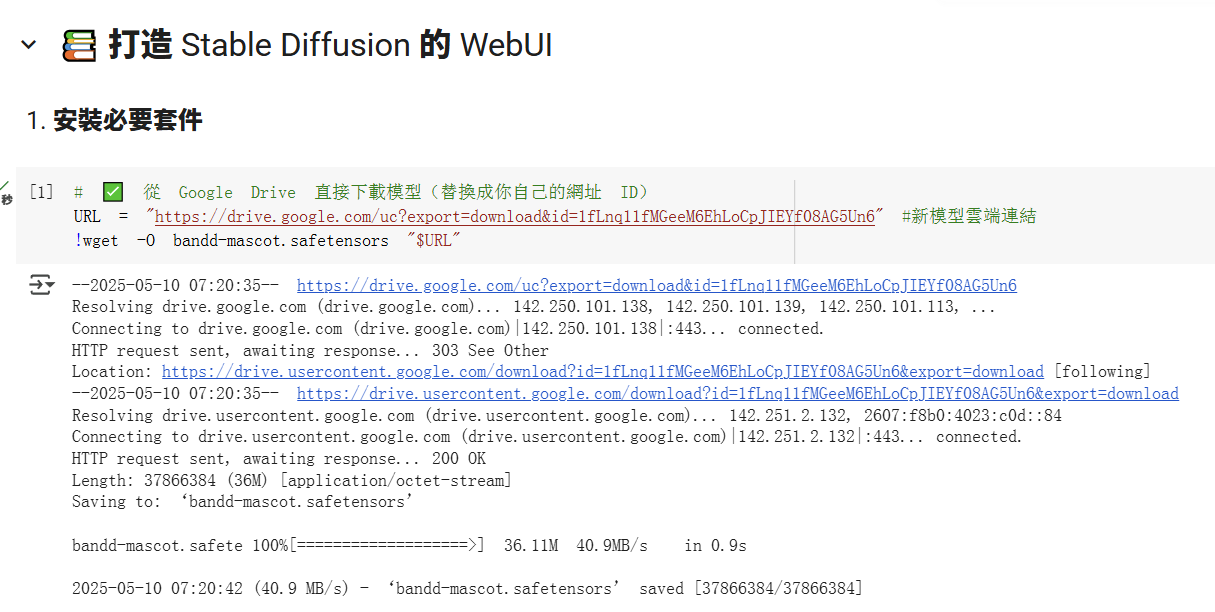

但試著改完後會出現錯誤，問了chatGPT才知道原來有些會不支援。

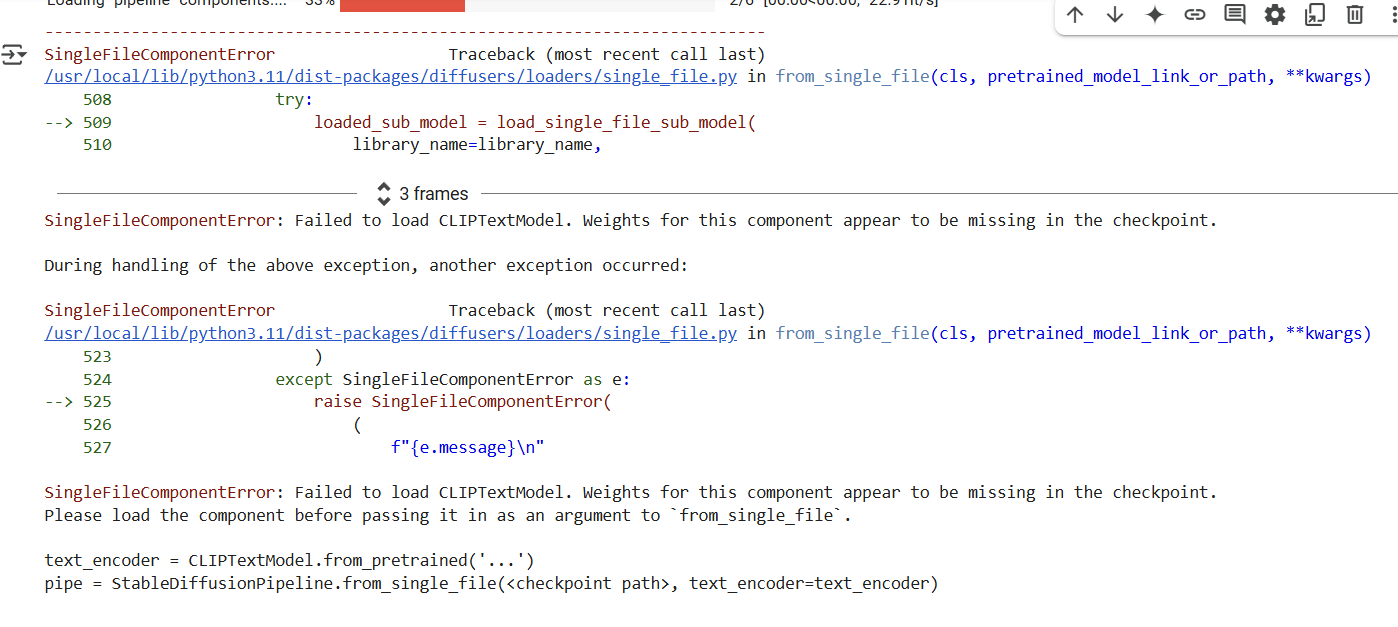
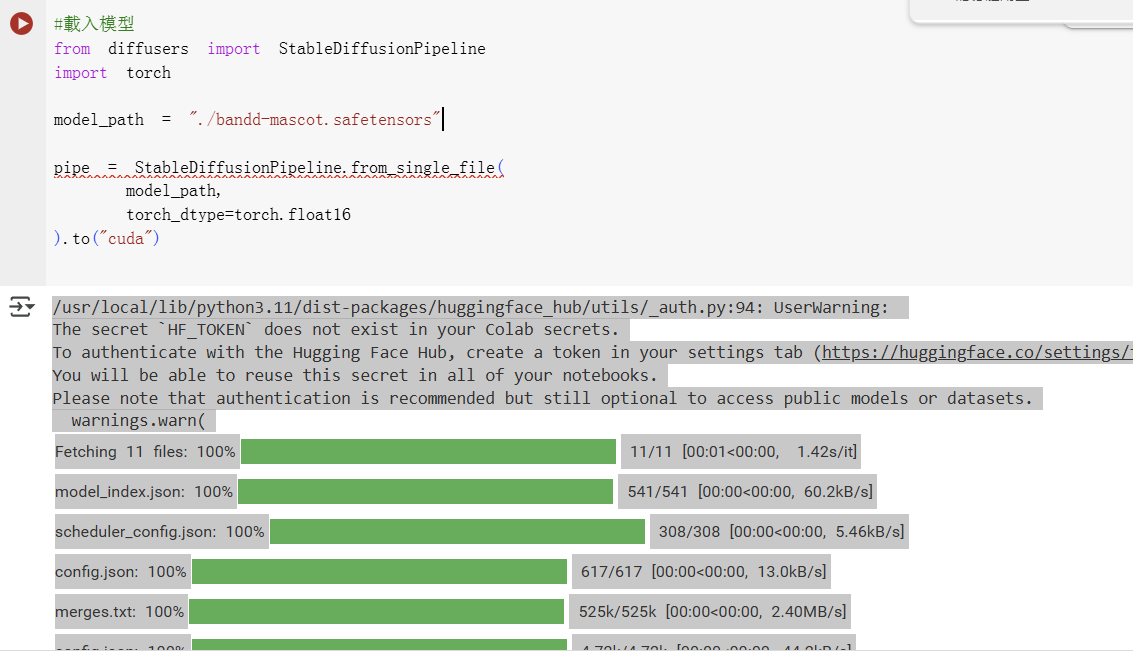
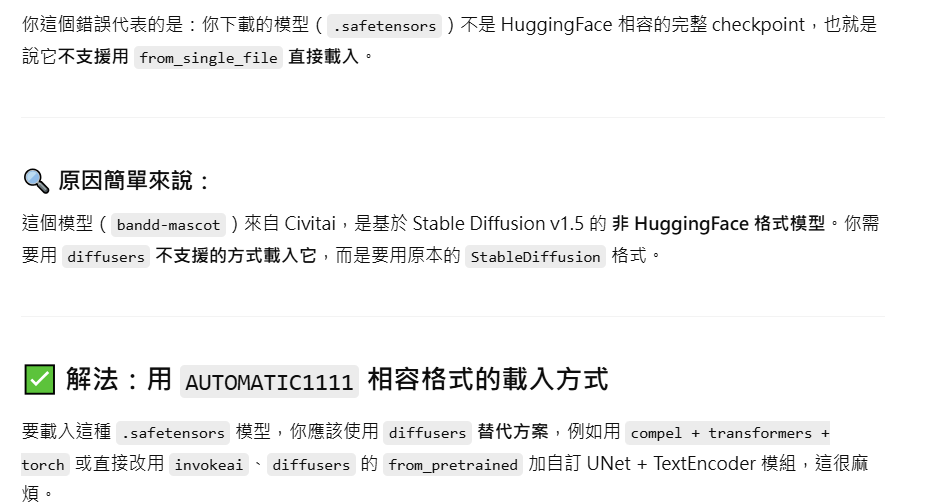

所以就放棄這個模型了，同時GPT推薦我改用 diffusers 官方支援的模型，也比較不怕別人檔案打不開。
因此我改為使用這個Lykon/dreamshaper-8新模型。


替換好模型後，首先保留老師的default_enhance 和 default_negative與各項數值，下面這是初步生成的結果:

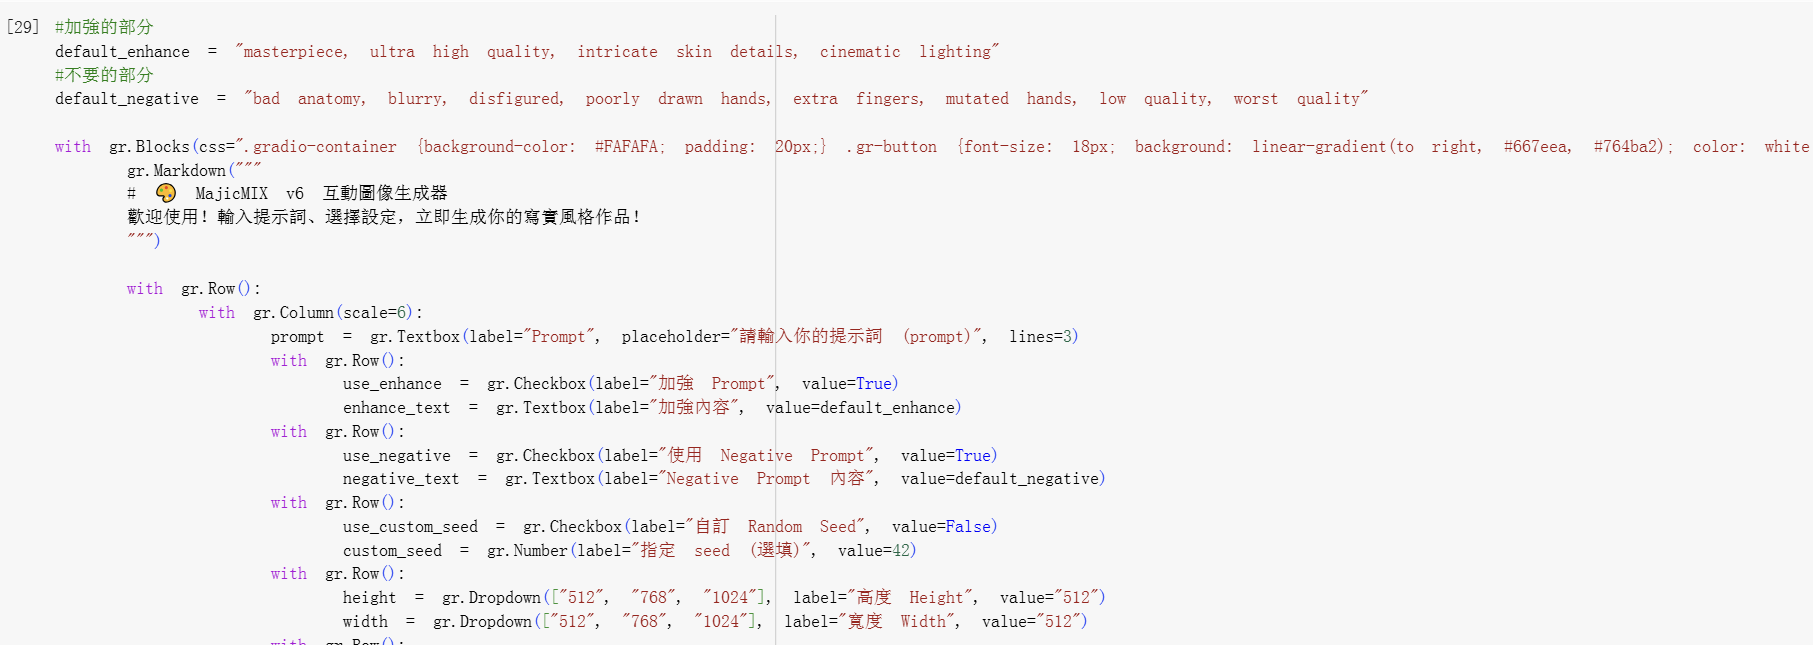

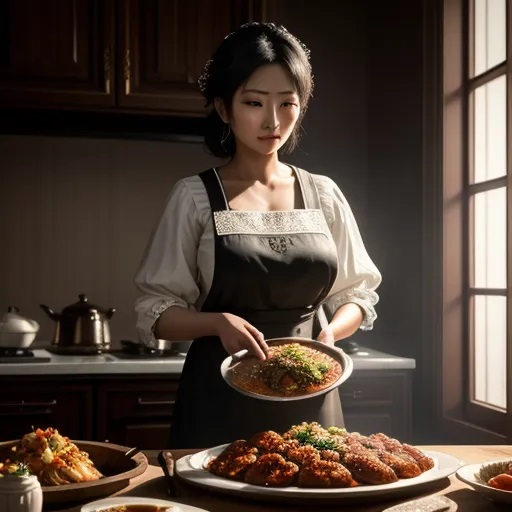

接著我又修改了default_enhance 和 default_negative。

#加強的部分 <br>
realistic photo	寫實風格照片 <br>
cozy home kitchen	溫馨的家庭廚房 <br>
warm lighting	溫暖的光線 <br>
natural skin texture	自然的皮膚質感 <br>
detailed table setting	餐桌擺設細節豐富 <br>
freshly cooked food	剛煮好的食物 <br>
gentle expression	溫柔的表情 <br>
motherly atmosphere	母親般的溫暖氛圍 <br>

#不要的部分 <br>
blurry	模糊不清 <br>
overexposed	過曝 <br>
unnatural pose	不自然的姿勢 <br>
distorted hands	扭曲的手部 <br>
odd food shapes	奇怪的食物形狀 <br>
exaggerated expressions	誇張的表情 <br>
low detail	細節不足 <br>
messy background	背景雜亂 <br>
cartoon style	卡通風格 <br>

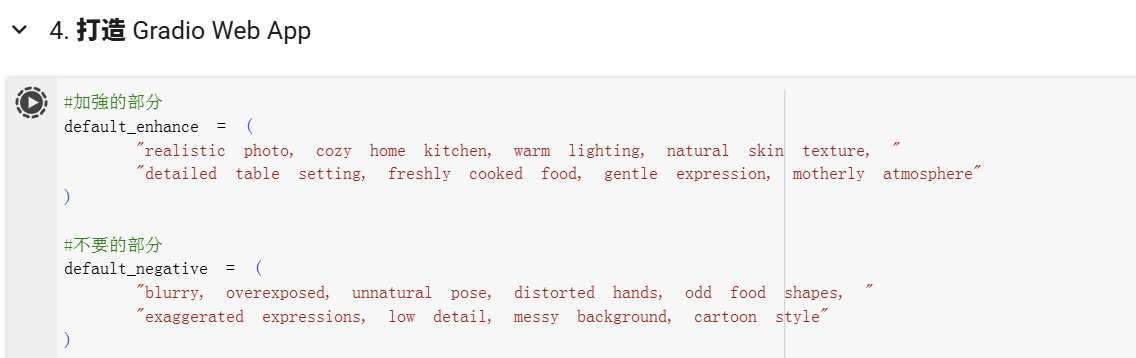

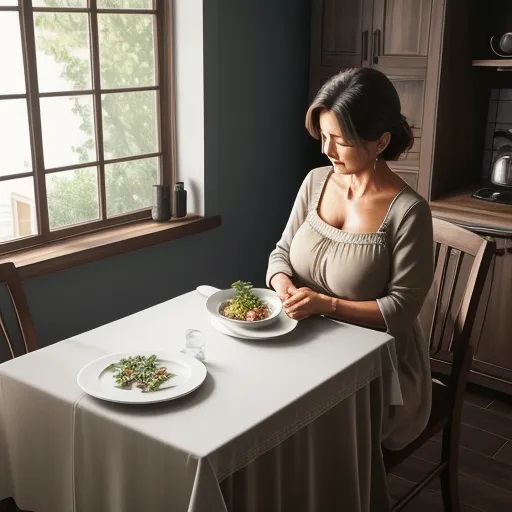

經過以上逐步新增的說明，終於生成了一張我想要的照片!!構圖良好且看得出光線和衣著情緒表情都能代表母親的身分， <br>
所以接著調整步數為30製作。

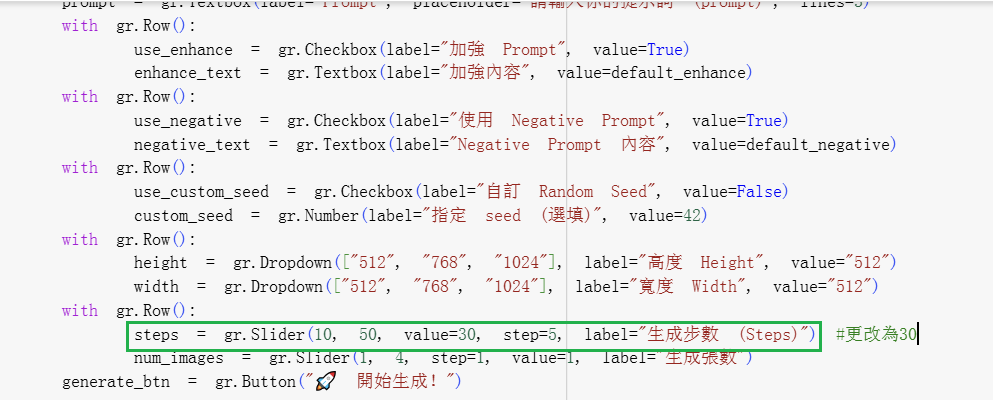

最終成果:
生成了一張相當有感覺的母親圖像，可以看到除了細節加強製作外，整理光線和氛圍都很有故事感！並且計算方法是有收斂的。

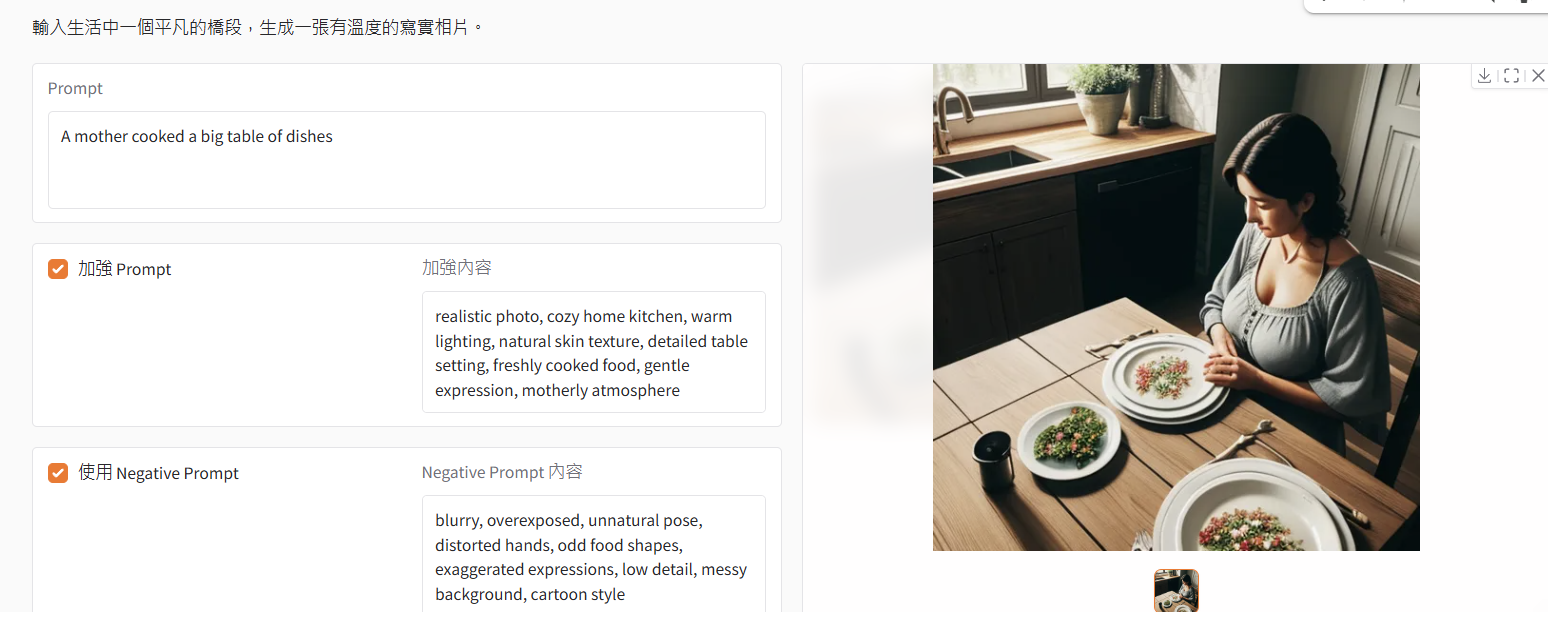

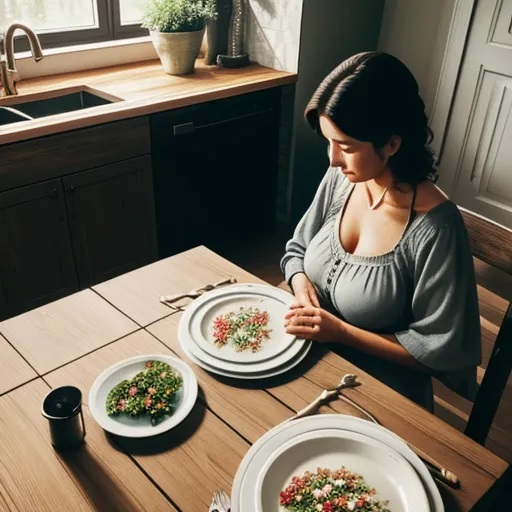